In [10]:
# Project 4: The Solar Atmosphere: Stratification and Continuous Spectrum

Imports needed to solve the following problems

In [16]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [40]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody  # to compute the Planck function
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from numpy import newaxis as nax  # to simplify the many uses of this

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

from scipy.integrate import cumtrapz   # for tau integration
from scipy.special import wofz   # for Voigt function

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Copy this cell whenever needed
    
Answer:

</div>

In [41]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = numpy.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

### Exercise 1: The FALC Model


<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Plot the total pressure $p_{\rm total}$ against the column mass $m$, both linearly and logarithmically.  You will find that they scale linearly.  Explain what assumption has caused $p_{\rm total} = c\,m$ and determine the value of the solar surface gravity $g_{\rm surface} = c$ that went into the FALC-producing code.
    
Answer:

</div>

c =  273.9818510028899 m / s2


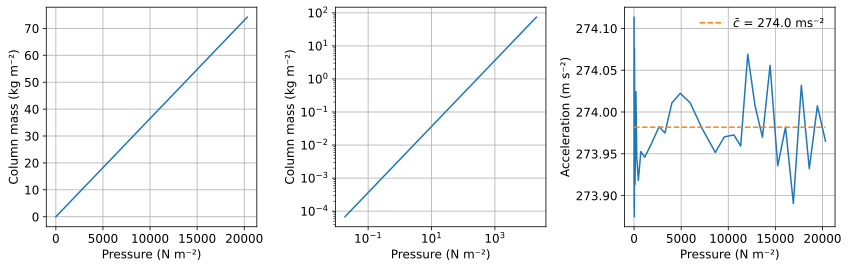

In [129]:
falc = read_table_units("falc.dat")

pressure = falc["pressure"]
colmass = falc["colmass"]

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.plot(pressure, colmass)
plt.grid()
plt.xlabel("Pressure (N m⁻²)")
plt.ylabel("Column mass (kg m⁻²)")

plt.subplot(132)
plt.loglog(pressure, colmass)
plt.grid()
plt.xlabel("Pressure (N m⁻²)")
plt.ylabel("Column mass (kg m⁻²)")

c = pressure/colmass
print("c = ", np.mean(c).decompose())
plt.subplot(133)
plt.plot(pressure, c)
plt.plot([pressure[0].value, pressure[-1].value], [np.mean(c.value),np.mean(c.value)], "--", label=r"$\bar{c}$ = %.1f ms⁻²" % np.mean(c.value))
plt.xlabel("Pressure (N m⁻²)")
plt.ylabel("Acceleration (m s⁻²)")
plt.legend()
plt.grid()
plt.tight_layout()


We notice from the left and middle plot that the pressure $p_{\textrm total}$ is linearly dependent on the coloumn mass $m$. This is because...

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* [Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F) also assumed complete mixing, *i.e.* the same elements mix at all heights. Check this by plotting the ratio of the hydrogen mass density to the total mass density against height. Then add helium to hydrogen using their abundance and mass ratios ($N_{\rm He}/N_{\rm H} = 0.1$, $m_{\rm He} = 3.97 \, m_{\rm H}$), and estimate the fraction of the total mass density made up by the remaining elements in the model mix (the "metals").
    
Answer:

</div>

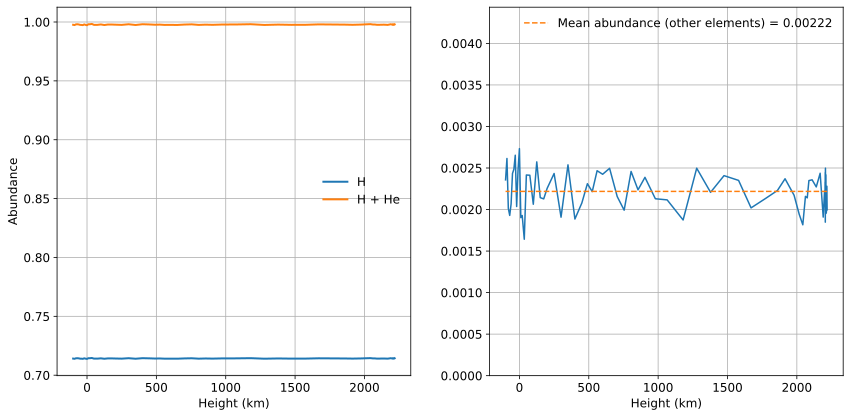

In [218]:
mass_H = constants.m_e + constants.m_p
density_H = falc["hydrogen_density"]
mass_density_H = mass_H * density_H

mass_He = 3.97 * mass_H
density_He = 0.1 * density_H
mass_density_He = mass_He * density_He

height = falc["height"].to('km')


plt.figure(figsize=[12,6])
plt.subplot(121)
plt.plot(height, mass_density_H/density, label="H", lw=2)
plt.plot(height, (mass_density_H + mass_density_He)/density, label="H + He", lw=2)
plt.grid()
plt.legend()
plt.xlabel("Height (km)")
plt.ylabel("Abundance")

#plt.tight_layout()

plt.subplot(122)
abundance_rest = 1 - mass_density_H/density - mass_density_He/density
mean_abund = np.mean(abundance_rest)
#plt.figure("Abundance of other elements", figsize=[12,6])
plt.plot(height, abundance_rest)
plt.plot([height[0].value, height[-1].value], [mean_abund, mean_abund],
         "--", label="Mean abundance (other elements) = %.5f" % mean_abund)

plt.ylim([mean_abund-mean_abund, mean_abund+mean_abund])
plt.legend()
plt.grid()
plt.xlabel("Height (km)")

plt.tight_layout()


We notice that the abundance of other elements (not hydrogen or helium) are almost constant, i.e. close to an average of 0.00222 relatively speaking.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Create a plot of the gas pressure against height, and then overplot the product $(n_{\rm H} + n_{\rm e}) \, k_B T$. Plot the ratio of the two curves to show their differences.  Do the differences measure deviations from the ideal gas law or something else? Now add the helium density $n_{\rm He}$ to the product and enlarge the deviations. Do you see a pattern emerging? Comment on what could be missing between your calculations and the gas pressure from the model.
    
Answer:

</div>

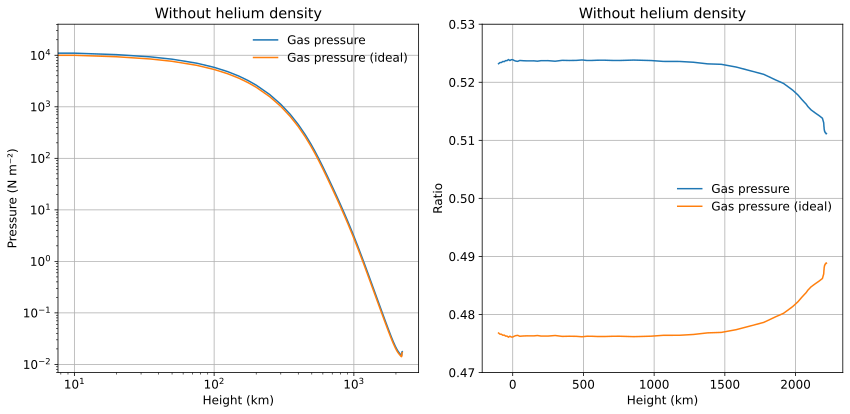

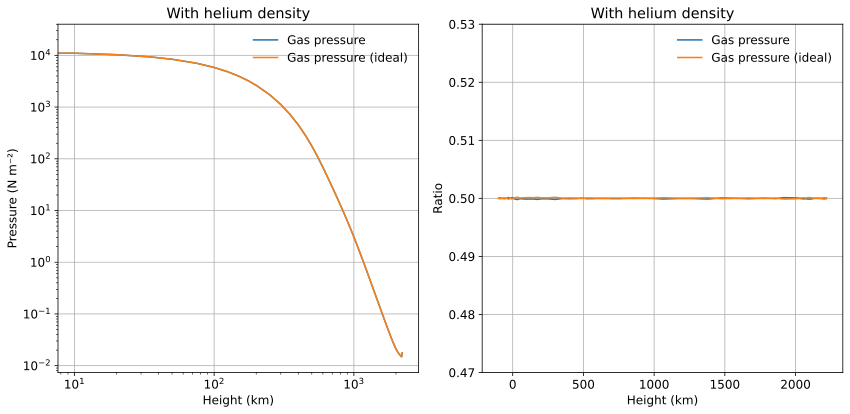

In [238]:
p_gas = falc["pressure"] - falc["density"] * falc["v_turb"]**2/2
p_gas_ideal = (falc["hydrogen_density"] + falc["electron_density"]) * constants.k_B * falc["temperature"]

plt.figure(figsize=[12, 6])
plt.subplot(121)
plt.title("Without helium density")
plt.loglog(height, p_gas, label="Gas pressure")
plt.loglog(height, p_gas_ideal, label="Gas pressure (ideal)")
plt.xlabel("Height (km)")
plt.ylabel("Pressure (N m⁻²)")
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Without helium density")
plt.plot(height, p_gas/(p_gas+p_gas_ideal), label="Gas pressure")
plt.plot(height, p_gas_ideal/(p_gas+p_gas_ideal), label="Gas pressure (ideal)")
plt.xlabel("Height (km)")
plt.ylabel("Ratio")
plt.legend()
plt.grid()
plt.ylim([0.47, 0.53])

plt.tight_layout()




p_gas = falc["pressure"] - falc["density"] * falc["v_turb"]**2/2
p_gas_ideal = (falc["hydrogen_density"] + falc["electron_density"] + density_He) * constants.k_B * falc["temperature"]

plt.figure("With He", figsize=[12, 6])
plt.subplot(121)
plt.title("With helium density")
plt.loglog(height, p_gas, label="Gas pressure")
plt.loglog(height, p_gas_ideal, label="Gas pressure (ideal)")
plt.xlabel("Height (km)")
plt.ylabel("Pressure (N m⁻²)")
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("With helium density")
plt.plot(height, p_gas/(p_gas+p_gas_ideal), label="Gas pressure")
plt.plot(height, p_gas_ideal/(p_gas+p_gas_ideal), label="Gas pressure (ideal)")
plt.xlabel("Height (km)")
plt.ylabel("Ratio")
plt.legend()
plt.grid()
plt.ylim([0.47, 0.53])

plt.tight_layout()




<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Plot the ionisation fraction of hydrogen logarithmically against height. Why does this curve look like the temperature stratification plotted earlier? And why is it tilted with respect to that?
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Let us now compare the photon and particle densities. In thermodynamic equilibrium (TE) the radiation is isotropic with intensity $I_\nu = B_\nu$ and has total energy density (Stefan Boltzmann)
    \begin{equation*}
         u = \frac{1}{c} \int\!\!\!\int B_\nu \mathrm{d}\Omega \mathrm{d}\nu
           = \frac{4\sigma}{c} T^4,
      \end{equation*} so that the total photon density for isotropic TE radiation is given, with $u_\nu = \rm{d} u/\rm{d} \nu$, $T$ in K and $N_{\rm phot}$ in photons per m$^3$, by  
    \begin{equation*}
         N_{\rm phot} = \int_0^\infty \frac{u_\nu}{h\nu} \mathrm{d} \nu
            \approx 20\,T^3.
         \label{eq:20T3}
      \end{equation*} 
    This equation gives a reasonable estimate for the photon density at the deepest model location. Compute the value there and compare it to the hydrogen density. Conjecture why this equation is not valid higher up in the atmosphere. 
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* In the upper atmosphere, the photon density there is given by $N_{\rm phot} \approx 20\,T_{\rm eff}^3/2\pi$, with $T_{\rm eff} = 5777$ K the effective solar temperature (since $\pi B(T_{\rm eff}) = \sigma T_{\rm eff}^3 = {\cal F^+} = \pi \overline{I^+}$ with ${\cal F^+}$ the emergent flux and $\overline{I^+}$ the disk-averaged emergent intensity). Compare it to the hydrogen density at the highest location in the FALC model. The medium there is insensitive to these photons (except those at the centre wavelength of the hydrogen Ly $\alpha$ line), why?
    
Answer:

</div>

### Exercise 2: Observed Solar Continua

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Plot the four spectral distributions together in one figure over the range $\lambda$ = 0-2 μm. Check that the continuum intensity (`i_cont`) reaches $I_\lambda^c$ = 46 kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$  at $\lambda$ 0.41 μm. Explain why the four distributions share the same units and discuss the differences between them.
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Convert these spectral distributions into values per frequency bandwidth $\Delta \nu$ = 1 Hz. Plot these also against wavelength. Check: peak $I_\nu^c$ = 4.21 nW m$^{-2}$ Hz$^{-1}$ sr$^{-1}$  at $\lambda$ = 0.80 μm.
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Try to fit a Planck function to the solar continuum intensity. What rough temperature estimate do you get?
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Invert the Planck function analytically to obtain an equation which converts an intensity distribution $I_\lambda$ into brightness temperature $T_b$ (defined by $B_\lambda(T_b) \equiv I_\lambda$). Code it as a function and use that to plot the brightness temperature of the solar continuum against wavelength. Discuss the shape of this curve. It peaks near $\lambda$ = 1.6 μm. What does that mean for the radiation escape at this wavelength?
    
Answer:

</div>

### Exercise 3: Continuous Extinction

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Using the function `compute_hminus_cross_section`, compute and plot the H$^-$ extinction for wavelengths between 300-1000 nm, and for the temperature and density at the solar surface (height = 0) in the FALC model.
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Hydrogenic bound-free edges behave just as H$^-$ with maximum extinction at the ionisation limit and decay $\sim \lambda^3$ for smaller wavelengths, as indeed shown by the H$^-$ curve. The H$^-$ bound-free extinction differs strongly from this pattern. Why is it not hydrogenic although due to hydrogen?
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* How should you plot this variation to make it look like the solar brightness temperature variation with wavelength? Why?
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Compute and plot the H$^-$ extinction as a function of height for the FALC model, at $\lambda$ = 0.5 μm. This plot needs to be logarithmic in y, why?
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Now add the Thomson scattering off free electrons to the extinction per m. The Thomson cross-section per electron is the same at all wavelengths and is given by       
\begin{equation*}
        \sigma^{\rm T} = 6.652 \times 10^{-29} \rm{m}^2.
\end{equation*} 
By which height-dependent quantity do you have to multiply this number to obtain extinction per m? Overplot this contribution to the continuous extinction $\alpha_\lambda^c(h)$ in your graph and then overplot the total continuous extinction too.  Note where which effect dominates.
    
Answer:

</div>